# Example: half-notched beam in three-point bending

Experimental results for the following example can be found in [1]. 

[1] Grégoire, D., Rojas‐Solano, L. B., & Pijaudier‐Cabot, G. (2013). Failure
and size effect for notched and unnotched concrete beams. International Journal
for Numerical and Analytical Methods in Geomechanics, 37(10), 1434-1452.

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt

try:
    import google.colab

    IN_COLAB = True
    !pip install git+https://github.com/mark-hobbs/pypd.git
    print("Package installed successfully")
    import pypd

    !sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended
except ImportError:
    IN_COLAB = False
    import pypd

    print("Not running in Colab")

Not running in Colab


In [2]:
if IN_COLAB:
    try:
        gpu_info = !nvidia-smi
        gpu_info = "\n".join(gpu_info)
        print("GPU Information:")
        print(gpu_info)
    except:
        print("GPU information not available")

    try:
        import multiprocessing

        cpu_info = f"Number of CPU cores: {multiprocessing.cpu_count()}"
        print("\nCPU Information:")
        print(cpu_info)
    except:
        print("CPU information not available")
else:
    print("Not running in Colab.")

Not running in Colab.


### Functions required to build the input file

In [3]:
mm_to_m = 1e-3
m_to_mm = 1e3

In [4]:
def build_particle_coordinates(dx, n_div_x, n_div_y):
    particle_coordinates = np.zeros([n_div_x * n_div_y, 2])
    counter = 0

    for i_y in range(n_div_y):  # Depth
        for i_x in range(n_div_x):  # Length
            coord_x = dx * i_x
            coord_y = dx * i_y
            particle_coordinates[counter, 0] = coord_x
            particle_coordinates[counter, 1] = coord_y
            counter += 1

    return particle_coordinates

In [5]:
def build_boundary_conditions(particles):
    bc_flag = np.zeros((len(particles), 2), dtype=np.intc)
    bc_unit_vector = np.zeros((len(particles), 2), dtype=np.intc)
    return bc_flag, bc_unit_vector

### Define functions to plot the experimental and numerical load-CMOD response

In [6]:
def load_data_file(filename="half_notched_beam.csv"):
    """
    Determine the location of the example and construct the path to the data
    file dynamically.
    """
    file_path = os.path.join(os.getcwd(), "data", filename)
    return np.genfromtxt(file_path, delimiter=",")

In [7]:
def load_data_file_github(
    filename="https://raw.githubusercontent.com/mark-hobbs/PyPD/main/examples/data/half_notched_beam.csv",
):
    import requests
    import io

    response = requests.get(filename)
    data = np.genfromtxt(io.StringIO(response.text), delimiter=",", skip_header=1)
    return data

In [8]:
def plot_load_cmod(model, n_div_z, fig_title="load-cmod", save_csv=False):
    load = -np.array(model.penetrators[0].penetrator_force_history) * n_div_z
    cmod = np.array(model.observations[1].history) - np.array(
        model.observations[0].history
    )

    fig, ax = plt.subplots(figsize=(8, 5))
    plot_experimental_data(ax)
    ax.plot((cmod[:, 0] * m_to_mm), load[:, 1], label="Numerical")

    ax.set_xlim(0, 0.20)
    ax.set_ylim(bottom=0)
    ax.set_xlabel("CMOD (mm)")
    ax.set_ylabel("Load (N)")
    ax.grid(True)
    ax.legend()

    fig.tight_layout()
    fig.savefig(fig_title, dpi=300)

    if save_csv == True:
        data = [(cmod[:, 0] * m_to_mm), load[:, 1]]
        np.savetxt(
            "load_cmod.csv", np.transpose(np.array(data)), delimiter=",", fmt="%f"
        )

In [9]:
def plot_experimental_data(ax):
    if IN_COLAB:
        data_file = load_data_file_github()
    else:
        data_file = load_data_file()

    cmod = data_file[:, 0]
    load_min = data_file[:, 1]
    load_max = data_file[:, 2]

    grey = (0.75, 0.75, 0.75)
    ax.plot(cmod, load_min, color=grey)
    ax.plot(cmod, load_max, color=grey)
    ax.fill_between(
        cmod,
        load_min,
        load_max,
        color=grey,
        edgecolor=None,
        label="Experimental",
    )

### Build the particles and boundary conditions

In [10]:
dx = 2.5 * mm_to_m
length = 175 * mm_to_m
depth = 50 * mm_to_m
width = 50 * mm_to_m
n_div_x = np.rint(length / dx).astype(int)
n_div_y = np.rint(depth / dx).astype(int)
n_div_z = np.rint(width / dx).astype(int)
notch = [
    np.array([(length * 0.5) + (dx * 0.5), 0]),
    np.array([(length * 0.5) + (dx * 0.5), depth * 0.5]),
]

In [11]:
x = build_particle_coordinates(dx, n_div_x, n_div_y)
flag, unit_vector = build_boundary_conditions(x)  # TODO: not needed

### Build the model

In [12]:
material = pypd.Material(name="quasi-brittle", E=37e9, Gf=143.2, density=2346, ft=3.9e6)
bc = pypd.BoundaryConditions(
    flag, unit_vector, magnitude=0
)  # TODO: boundary conditions are not required as this example uses a contact model
particles = pypd.ParticleSet(x, dx, bc, material)
bonds = pypd.BondSet(particles, constitutive_law=pypd.NonLinear, surface_correction=True, notch=notch)
simulation = pypd.Simulation(n_time_steps=200000, damping=0, dt=None)

radius = 25 * mm_to_m
penetrators = []
penetrators.append(
    pypd.Penetrator(
        np.array([0.5 * length, depth + radius - dx]),
        np.array([0, 1]),
        np.array([0, -0.4 * mm_to_m]),
        radius,
        particles,
        name="Penetrator",
        plot=False,
    )
)
penetrators.append(
    pypd.Penetrator(
        np.array([0.5 * depth, -radius]),
        np.array([0, 0]),
        np.array([0, 0]),
        radius,
        particles,
        name="Support - left",
        plot=False,
    )
)
penetrators.append(
    pypd.Penetrator(
        np.array([3 * depth, -radius]),
        np.array([0, 0]),
        np.array([0, 0]),
        radius,
        particles,
        name="Support - right",
        plot=False,
    )
)

observations = []
observations.append(
    pypd.Observation(
        np.array([77.5 * mm_to_m, 0]), particles, period=1, name="CMOD - left"
    )
)
observations.append(
    pypd.Observation(
        np.array([97.5 * mm_to_m, 0]), particles, period=1, name="CMOD - right"
    )
)

nonlinear_model = pypd.Model(particles, 
                             bonds, 
                             simulation, 
                             integrator=pypd.EulerCromer(), 
                             penetrators=penetrators, 
                             observations=observations)

/Users/markhobbs/Documents/02-repositories/pypd/pypd/tools.py:93: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = alpha_numerator / denominator
/Users/markhobbs/Documents/02-repositories/pypd/pypd/tools.py:94: RuntimeWarning: divide by zero encountered in scalar divide
  beta = beta_numerator / denominator


### Run the simulation and plot the final state and predicted load-CMOD response

In [13]:
nonlinear_model.run_simulation()

Simulation Progress: 100%|██████████████████████████████████████████████████████| 200000/200000 [00:57<00:00, 3461.37steps/s]


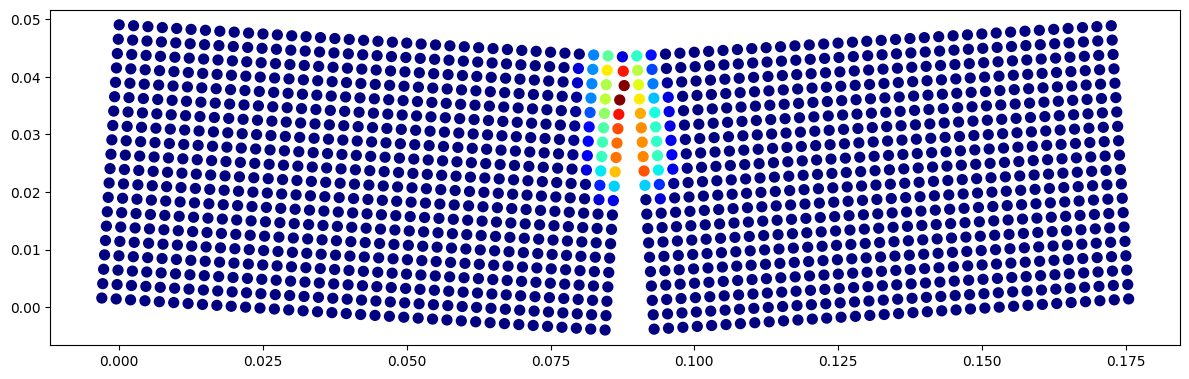

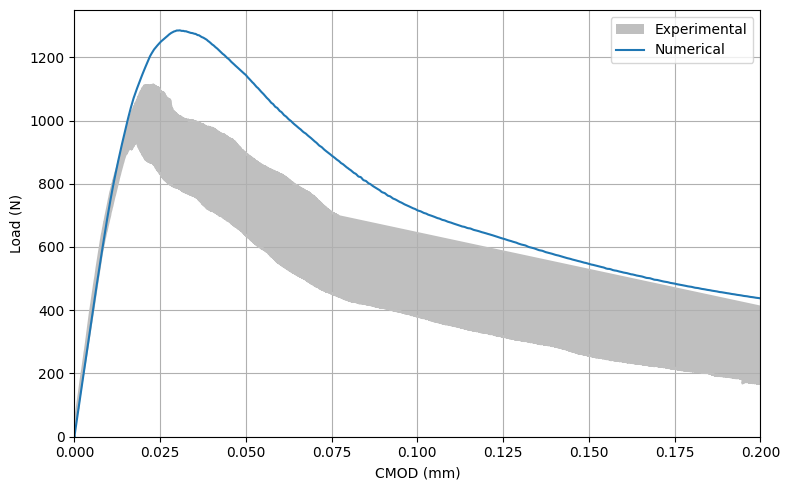

In [14]:
nonlinear_model.save_final_state_fig(sz=50, dsf=10, fig_title="half-notched-beam")
plot_load_cmod(nonlinear_model, n_div_z, fig_title="load-cmod-nonlinear")